## Imports

In [1]:
!pip install chainercv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.6/260.6 kB 5.5 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.7 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for chainercv: filename=chainercv-0.13.1-cp37-cp37m-linux_x86_64.whl size=553158 sha256=e4317893f335be64ebbbed291817143e6378e99fb7e03dbf553a31b0c12940bd
  Stored in directory: /root/.cache/pip/wheels/d0/25/65/69b903887d07424c5b971f5676f1151b32dc971df0f710097c
  Created wheel for chainer: filename=chainer-7.8.1-py3-none-any.whl size=967740 sha256=e6d5649aeafd70403911ebf766ed87e181c3b07900438cde44b259d2990a37c6
  Stored in directory: /root/.cache/pip/wheels/c8/6a/6f/fd563166cc597e5206e375ea074ea836e5db5dd58421215672
Successfully built chainercv chainer


In [11]:
import torchvision
import torch
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from chainercv.links import YOLOv3
from chainercv.utils import read_image

device = torch.device('gpu') if torch.cuda.is_available() else torch.device('cpu')

## Prepare data

С помощью сети для детекции найдём птиц для их выделения с изображения

(Используется chainercv, тк он хорошо находит птиц на изображении из коробки, в отличии от PyTorch. Такой же детектор используется в https://github.com/loubnabnl/Bird-species-classification-with-Computer-Vision)

In [3]:
model_crop = YOLOv3(pretrained_model='voc0712')

From: https://chainercv-models.preferred.jp/yolo_v3_voc0712_converted_2018_05_01.npz
To: /root/.chainer/dataset/_dl_cache/79d417010adfc0e1052bb8e5c4851753
  %   Total    Recv       Speed  Time left
100  219MiB  219MiB   6804KiB/s    0:00:00

/opt/conda/lib/python3.7/site-packages/chainercv/utils/link.py:72: RuntimeWarning: Although the pretrained model is trained using cv2 as the backend of resize function, the current setting does not use cv2 as the backend of resize function. The performance may change due to using different backends. To suppress this warning, set `chainer.config.cv_resize_backend = "cv2".
  RuntimeWarning)


In [4]:
def add_boxes_to_img(img, boxes_list):
    for temp_box in boxes_list:
        y0, x0, y1, x1 = temp_box
        
        cv2.rectangle(img, (int(x0), int(y0)), (int(x1), int(y1)), color=(255, 0, 0), thickness=2)
        
    return img

In [5]:
%%time
test_img = read_image('/kaggle/input/birds-classification-dataset/birds_classification/train/0/04.jpg')

chainer_ans = model_crop.predict([test_img])

bboxes, labels, scores = chainer_ans

CPU times: user 5.99 s, sys: 2.97 s, total: 8.96 s
Wall time: 2.42 s


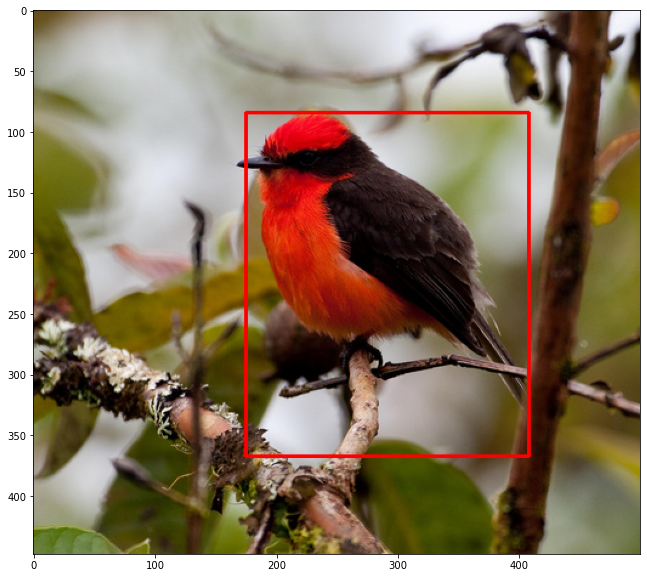

In [6]:
#orig_img = np.ascontiguousarray(torch.permute(torch.tensor(test_img, dtype=torch.uint8), (1, 2, 0)).numpy())
orig_img = np.swapaxes(np.swapaxes(np.array(test_img, dtype=np.uint8), 0, 1), 1, 2)

pic_with_rec = add_boxes_to_img(orig_img, bboxes[0])

plt.figure(figsize=(20, 10))
plt.imshow(pic_with_rec)

Обработаем все изображения и сохраним в отдельную папку, для дальнейшего использования

In [13]:
def preprocess_images_folder(img_dir_path, crop_model):
    # Load images
    file_name_list = sorted(os.listdir(img_dir_path))
    raw_imgs_list = [read_image(os.path.join(img_dir_path, temp_img)) for temp_img in file_name_list]
    
    #print(raw_imgs_list)
    
    # Predict bounding boxes
    model_predictions = model_crop.predict(raw_imgs_list)
    
    #print(model_predictions)
    
    for temp_raw_img, temp_bbox, temp_old_file_name in zip(raw_imgs_list, model_predictions[0], file_name_list):
        orig_img = np.swapaxes(np.swapaxes(np.array(temp_raw_img, dtype=np.uint8), 0, 1), 1, 2)
        
        if temp_bbox.size > 0:
            y0, x0, y1, x1 = temp_bbox[0]

            cropped_img = orig_img[int(y0)-10:int(y1)+10, int(x0)-10:int(x1)+10, :]

            new_folder_path = os.path.join(img_dir_path.replace('input', 'working'))
            if not os.path.exists(new_folder_path):
                os.makedirs(new_folder_path)

            if cropped_img.size > 0:
                cv2.imwrite(os.path.join(new_folder_path, temp_old_file_name), cropped_img)
                continue
        
        cv2.imwrite(os.path.join(new_folder_path, temp_old_file_name), orig_img)

In [8]:
%%time
preprocess_images_folder('/kaggle/input/birds-classification-dataset/birds_classification/train/0', model_crop)

CPU times: user 30.7 s, sys: 14.4 s, total: 45.2 s
Wall time: 14.6 s


Результат работы препроцессинга для одного каталога

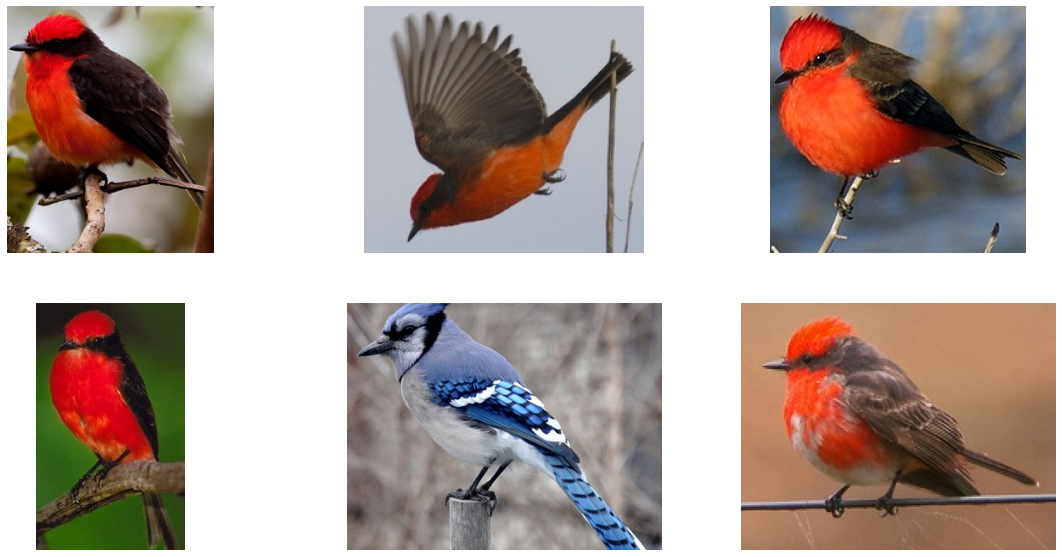

In [9]:
temp_files = os.listdir('/kaggle/working/birds-classification-dataset/birds_classification/train/0/')

fig, axes = plt.subplots(len(temp_files) // 3, 3, figsize=(20, 10))
axes = axes.reshape(1, -1)[0]

for temp_img_name, temp_ax in zip(temp_files, axes):
    temp_ax.axis('off')
    
    temp_img = cv2.imread(os.path.join('/kaggle/working/birds-classification-dataset/birds_classification/train/0/', temp_img_name))
    
    temp_ax.imshow(temp_img)

In [ ]:
%%time
for temp_folder in tqdm(os.listdir('/kaggle/input/birds-classification-dataset/birds_classification/train')):
    folder_path = os.path.join('/kaggle/input/birds-classification-dataset/birds_classification/train', temp_folder)
    preprocess_images_folder(folder_path, model_crop)

 18%|█▊        | 9/50 [05:59<24:24, 35.73s/it]